In [1]:
%matplotlib inline

import pickle
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from multiprocessing import Process

from BCModel import BCModel

In [2]:
data_path = Path('./expert_data/')
def load_data_from_pickle(envname):
    file_path = data_path / (envname + '.pkl')
    with open(file_path.resolve(), 'rb') as f:
        data = pickle.load(f)
    return data

In [3]:
envs = ['Hopper-v2', 'Ant-v2', 'HalfCheetah-v2', 'Humanoid-v2', 'Reacher-v2', 'Walker2d-v2']

In [4]:
min_loss = 1e-5
def estimateModel(env_name, training_epoch=5000):
    print('estimating %s...' % env_name)
    data = load_data_from_pickle(env_name)
    train_inputs = data['observations']
    train_outputs = data['actions']
    train_outputs = np.reshape(train_outputs, (train_outputs.shape[0], train_outputs.shape[2]))
    print('estimate env %s' % env_name)
    print('train_inputs shape is: ', train_inputs.shape)
    print('train_outputs shape is: ', train_outputs.shape)
    
    model_params = {
        'env_name': env_name,
        'input_dim': train_inputs.shape[1],
        'output_dim': train_outputs.shape[1],
        'learning_rate': 1e-6,
        'batch_size': 512
    }

    model = BCModel(**model_params)
    model.build()
     
    epochs = []
    losses = []
    mean_returns = []
    std_returns = []
    for epoch in range(training_epoch + 1):
        batch = model.generate_batch(train_inputs, train_outputs)
        loss = model.train_on_batch(*batch)
        if loss < min_loss:
            break
        if epoch % 500 == 0:
            returns = model.evaluate_reward()
            epochs.append(epoch)
            losses.append(loss)
            mean_returns.append(np.mean(returns))
            std_returns.append(np.std(returns))
    
    with open('%s_train.pkl' % env_name, 'wb') as f:
        data = {
            'epochs': epochs,
            'losses': losses,
            'mean_returns': mean_returns,
            'std_returns': std_returns
        }
        pickle.dump(data, f)
    print('estimating %s...finished' % env_name)

In [5]:
# estimate all model
training_epoch = 5000
pros = []
for env_name in envs:
    process = Process(target=estimateModel, args=(env_name, training_epoch))
    # estimateModel(env_name, training_epoch)
    process.start()
    pros.append(process)

for p in pros:
    p.join()

estimating Hopper-v2...
estimating Ant-v2...
estimating HalfCheetah-v2...
estimate env Hopper-v2
train_inputs shape is:  (20000, 11)
estimating Humanoid-v2...
train_outputs shape is:  (20000, 3)
estimate env HalfCheetah-v2
estimating Reacher-v2...
train_inputs shape is:  (20000, 17)
train_outputs shape is:  (20000, 6)
estimate env Reacher-v2
train_inputs shape is:  (1000, 11)
estimating Walker2d-v2...
train_outputs shape is:  (1000, 2)
estimate env Ant-v2
train_inputs shape is:  (19045, 111)
estimate env Walker2d-v2
train_outputs shape is:  (19045, 8)
train_inputs shape is:  (20000, 17)
train_outputs shape is:  (20000, 6)
estimate env Humanoid-v2
train_inputs shape is:  (20000, 376)
train_outputs shape is:  (20000, 17)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Pleas

In [8]:
data = {}
for env_name in envs:
    with open('%s_train.pkl' % env_name, 'rb') as f:
        data[env_name] = pickle.load(f)
from pprint import pprint
pprint(data)

{'Ant-v2': {'epochs': [0,
                       500,
                       1000,
                       1500,
                       2000,
                       2500,
                       3000,
                       3500,
                       4000,
                       4500,
                       5000],
            'losses': [0.68348402,
                       0.6866079,
                       0.68217313,
                       0.68443513,
                       0.68342257,
                       0.68243819,
                       0.68297327,
                       0.68235928,
                       0.67685306,
                       0.67506325,
                       0.67548597],
            'mean_returns': [949.00799944821051,
                             948.98168501850728,
                             942.27893651836007,
                             953.14929915331709,
                             907.55153642139737,
                             903.62835224416153,
     

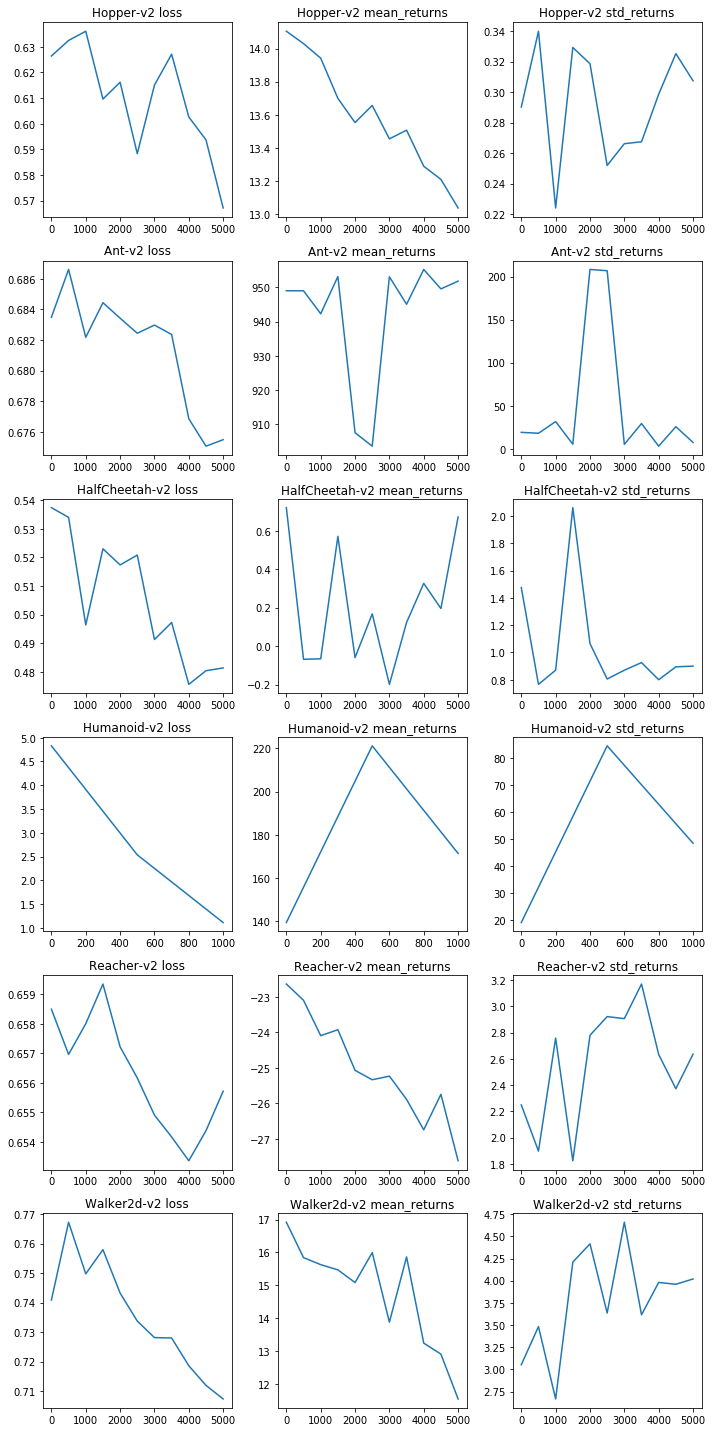

In [9]:
# plot all data
plt.figure(figsize=(10,20))

for idx in range(len(envs)):
    env_name = envs[idx]
    plt.subplot(len(envs), 3, (idx) * 3 + 1)
    plt.title('%s loss' % env_name)
    plt.plot(data[env_name]['epochs'], data[env_name]['losses'])
    plt.tight_layout() 
    
    plt.subplot(len(envs), 3, (idx) * 3 + 2)
    plt.title('%s mean_returns' % env_name)
    plt.plot(data[env_name]['epochs'], data[env_name]['mean_returns'])
    plt.tight_layout()
    
    plt.subplot(len(envs), 3, (idx) * 3 + 3)
    plt.title('%s std_returns' % env_name)
    plt.plot(data[env_name]['epochs'], data[env_name]['std_returns'])
    plt.tight_layout()